In [ ]:
!pip -q install monai gdown einops mlflow pynrrd torchinfo 
!pip install pandas numpy nibabel tqdm
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [1]:
import os
from glob import glob
import shutil
import tempfile
import time
import warnings
import torch
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from collections.abc import Callable, Sequence, Hashable
from typing import Mapping,Dict
import matplotlib.pyplot as plt

from monai.transforms import (
    EnsureType,
    FillHoles,
    OneOf,
    SpatialCropd,
    Activations,
    Activationsd,
    ConcatItemsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    RandAffined,
    NormalizeIntensityd,
    ToTensord,
    EnsureChannelFirstd ,
    Orientationd,
    Spacingd,
    ScaleIntensityRanged,
    CropForegroundd,
    NormalizeIntensityd,
    Resized,
    SaveImaged,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    RandSpatialCropSamplesd,
    RandFlipd,
    RandRotated,
    EnsureTyped,
    ScaleIntensityd,
    RandCropByPosNegLabeld,
)

from monai.apps import DecathlonDataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.nets import SegResNet
from monai.data import Dataset, DataLoader, CacheDataset, decollate_batch
from monai.utils import first
from monai.utils import set_determinism
from monai.config import print_config
from monai.data.meta_tensor import MetaTensor
from monai.config.type_definitions import NdarrayOrTensor
from monai.utils.misc import ImageMetaKey

In [3]:
set_determinism(seed=123)

In [4]:
root_dir = 'Hecktor22/model_data'
data_dir = 'hecktor2022_training/hecktor2022'
resampled_ct_path = 'hecktor2022_training/hecktor2022/resampled_largerCt'
resampled_pt_path = 'hecktor2022_training/hecktor2022/resampled_largerPt'
resampled_label_path = 'hecktor2022_training/hecktor2022/resampled_largerlabel'

train_images = sorted(
    glob(os.path.join(data_dir, "imagesTr", "*_CT*")))
train_images2 = sorted(
    glob(os.path.join(data_dir, "imagesTr", "*_PT*")))
train_labels = sorted(
    glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "image2": pet_image, 'label': label_name}
    for image_name, pet_image, label_name in zip(train_images, train_images2, train_labels)
]
len(data_dicts)

524

In [5]:
print(len(train_images))
print(len(train_images2))
print(len(train_labels))

524
524
524


In [7]:
import os

folder_path = 'hecktor2022_training/hecktor2022/imagesTr'
files_greater_than_60mb = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_size_mb = os.path.getsize(file_path) / (1024 * 1024)  # Convert file size to MB
        if file_size_mb > 40:
            files_greater_than_60mb.append(file_path)

print(len(files_greater_than_60mb))      

patients_greater_than_60mb = set()
for file in files_greater_than_60mb:
    file = file.split('/')[-1]
    file = file.split('_')[0]
    patients_greater_than_60mb.add(file)

patients_greater_than_60mb = list(patients_greater_than_60mb)
print(len(patients_greater_than_60mb))

230
230


In [8]:
files = train_images
substrings_to_remove = patients_greater_than_60mb

filtered_files = [file for file in files if not any(substring in file for substring in substrings_to_remove)]

train_images = filtered_files
len(train_images)

294

In [9]:
files = train_images2
substrings_to_remove = patients_greater_than_60mb

filtered_files = [file for file in files if not any(substring in file for substring in substrings_to_remove)]

train_images2 = filtered_files
len(train_images2)

294

In [10]:
files = train_labels
substrings_to_remove = patients_greater_than_60mb

filtered_files = [file for file in files if not any(substring in file for substring in substrings_to_remove)]

train_labels = filtered_files
len(train_labels)

294

In [11]:
data_dicts = [{"image": image_name, "image2": pet_image, 'label': label_name}
    for image_name, pet_image, label_name in zip(train_images, train_images2, train_labels)
]
len(data_dicts)

294

In [12]:
import random
x=[i for i in range(294)]
# print(x)
random.shuffle(x)
# print(x)
train_index,val_index,test_index=x[:200],x[200:290],x[290:]
train_files=[]
val_files=[]
test_files=[]
for i in train_index:
    train_files.append(data_dicts[i])
for i in val_index:
    val_files.append(data_dicts[i])
for i in test_index:
    test_files.append(data_dicts[i])

In [13]:
print(len(train_files))
print(len(val_files))
print(len(test_files))

200
90
4


In [14]:
train_files[22]

{'image': 'hecktor2022_training/hecktor2022/imagesTr/CHUS-090__CT.nii.gz',
 'image2': 'hecktor2022_training/hecktor2022/imagesTr/CHUS-090__PT.nii.gz',
 'label': 'hecktor2022_training/hecktor2022/labelsTr/CHUS-090.nii.gz'}

In [ ]:
# root_dir = 'model_data'
# data_dir = 'Hecktor22/data'

# train_images_ct = sorted(glob(os.path.join(data_dir, 'TrainData', '*_CT.nii.gz')))
# train_images_pt = sorted(glob(os.path.join(data_dir, 'TrainData', '*_PT.nii.gz')))
# train_labels = sorted(glob(os.path.join(data_dir, 'TrainLabels', '*.nii.gz')))
# train_files = [{"image": image_name, "image2": pet_image, 'label': label_name} for image_name, pet_image, label_name in zip(train_images_ct, train_images_pt, train_labels)]

# val_images_ct = sorted(glob(os.path.join(data_dir, 'ValData', '*_CT.nii.gz')))
# val_images_pt = sorted(glob(os.path.join(data_dir, 'ValData', '*_PT.nii.gz')))
# val_labels = sorted(glob(os.path.join(data_dir, 'ValLabels', '*.nii.gz')))
# val_files = [{"image": image_name, "image2": pet_image, 'label': label_name} for image_name, pet_image, label_name in zip(val_images_ct, val_images_pt, val_labels)]

In [ ]:
# print(train_files)
# print(val_files)

In [30]:
class HecktorCropNeckRegion(CropForegroundd):
    """
    A simple pre-processing transform to approximately crop the head and neck region based on a PET image.
    This transform relies on several assumptions of patient orientation with a head location on the top,
    and is specific for Hecktor22 dataset, and should not be used for an arbitrary PET image pre-processing.
    """
    
    def __init__(
        self,
        keys=["image", "image2", "label"],
        source_key="image",
        box_size=[200, 200, 310],
        allow_missing_keys=True,
        **kwargs,
    ) -> None:
        super().__init__(keys=keys, source_key=source_key, allow_missing_keys=allow_missing_keys, **kwargs)
        self.box_size = box_size

    def __call__(self, data : Mapping[Hashable, torch.Tensor]) -> Dict[Hashable, torch.Tensor]:
        
        d = dict(data)
        im_pet = d["image2"][0]
        label = d["label"][0]
        #print(im_pet)
        box_size = np.array(self.box_size)  # H&N region to crop in mm , defaults to 200x200x310mm
        filename = ""

        if isinstance(im_pet, MetaTensor):
            filename = im_pet.meta[ImageMetaKey.FILENAME_OR_OBJ]
            box_size = (box_size / np.array(im_pet.pixdim)).astype(int)  # compensate for resolution

        box_start, box_end = self.extract_roi(im_pet=im_pet, box_size=box_size)
        # file = label.meta[ImageMetaKey.FILENAME_OR_OBJ]
        # file = file.split('/')[-1]
        # file = file.split('_')[0]
        # print(file, ":", box_start, box_end)
        
        if "label" in d and "label" in self.keys:
            # if label mask is available, let's check if the cropped region includes all foreground
            before_sum = d["label"].sum().item()
            after_sum = (
                (d["label"][:, box_start[0] : box_end[0], box_start[1] : box_end[1], box_start[2] : box_end[2]])
                .sum()
                .item()
            )
            if before_sum != after_sum:
                # print(d['image'].meta[ImageMetaKey.FILENAME_OR_OBJ])
                # print(d['image2'].meta[ImageMetaKey.FILENAME_OR_OBJ])
                # print(file)
                print("WARNING, H&N crop could be incorrect!!!", before_sum, after_sum)
                

        d[self.start_coord_key] = box_start
        d[self.end_coord_key] = box_end
        
        for key, m in self.key_iterator(d, self.mode): #question: what is mode in the iterators?
            # print(key, m)
            self.push_transform(d, key, extra_info={"box_start": box_start, "box_end": box_end})
            d[key] = self.cropper.crop_pad(img=d[key], box_start=box_start, box_end=box_end, mode=m)
        # print(d['image'].shape)
        # print(d['image2'].shape)
        # print(d['label'].shape)
        return d

    def extract_roi(self, im_pet, box_size):

        crop_len = int(0.75 * im_pet.shape[2])
        im = im_pet[..., crop_len:]

        mask = ((im - im.mean()) / im.std()) > 1
        comp_idx = torch.argwhere(mask)
        center = torch.mean(comp_idx.float(), dim=0).cpu().int().numpy()
        xmin = torch.min(comp_idx, dim=0).values.cpu().int().numpy()
        xmax = torch.max(comp_idx, dim=0).values.cpu().int().numpy()

        xmin[:2] = center[:2] - box_size[:2] // 2
        xmax[:2] = center[:2] + box_size[:2] // 2

        xmax[2] = xmax[2] + crop_len
        xmin[2] = max(0, xmax[2] - box_size[2])

        return xmin.astype(int), xmax.astype(int)

In [31]:
class CalculateCentreOfMass(CropForegroundd):
        def __init__(self, keys=["image", "image2", "label"], source_key="image", **kwargs):
            super().__init__(keys=keys, source_key=source_key, **kwargs)
        def __call__(self, data : Mapping[Hashable, torch.Tensor]):
            d = dict(data)
            def CalculateCenterOfMass():
                image_tensor = d["image2"][0]
                meshgrid = torch.meshgrid([torch.arange(image_size) for image_size in image_tensor.shape])
                center_of_mass = torch.stack([torch.sum(image_tensor * meshgrid[dim]) / torch.sum(image_tensor) for dim in range(3)])
                return [round(num) for num in center_of_mass.tolist()]
            # SpatialCropd(keys=["image", "image2", "label"],roi_center = CalculateCenterOfMass(), roi_size=[192, 192, 192])
            return SpatialCropd(keys=["image", "image2", "label"], roi_center = CalculateCenterOfMass(), roi_size=[192, 192, 192])(d)

In [32]:
class ConvertToMultiChannelBasedOnClassesd(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key] == 1)
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

In [33]:
ct_a_min = -200
ct_a_max = 400
pt_a_min = 0
pt_a_max = 25
# if __name__ == "__main__":
# device = torch.device("cuda:0")
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "image2", "label"]),
        EnsureChannelFirstd(keys = ["image", "image2",]),
        EnsureTyped(keys=["image", "image2", "label"]),
        ConvertToMultiChannelBasedOnClassesd(keys="label"),
        Orientationd(keys=["image", "image2", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "image2", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=['bilinear', 'bilinear', 'nearest'],
        ),
        HecktorCropNeckRegion(keys=["image", "image2", "label"], source_key="image"),
        # RandSpatialCropd(keys=["image", "image2", "label"], roi_size=[192, 192, 192], random_size=False),
        CalculateCentreOfMass(keys=["image", "image2", "label"], source_key="image"),
        ScaleIntensityd(keys=["image", "image2"], minv=0.0, maxv=1.0),
        # ScaleIntensityRanged(keys=['image'], a_min=ct_a_min, a_max=ct_a_max, b_min=0.0, b_max=1.0, clip=True),
        # ScaleIntensityRanged(keys=['image2'], a_min=pt_a_min, a_max=pt_a_max, b_min=0.0, b_max=1.0, clip=True),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        NormalizeIntensityd(keys="image2", nonzero=True, channel_wise=True),
        RandFlipd(keys=["image", "image2", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "image2", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "image2", "label"], prob=0.5, spatial_axis=2),
        ToTensord(keys=["image", "image2", "label"]),
        ConcatItemsd(keys=["image", "image2"], name="image_petct", dim=0),
        # RandRotated(keys=["image", "image2", "label"], prob = 0.5),
        # SaveImaged(
        # keys = ['image', 'image2', 'label'],
        # output_dir='data/output',
        # output_postfix="crop",
        # resample=False,
        # output_dtype=np.int16,
        # separate_folder=False,
        # )
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "image2", "label"]),
        EnsureChannelFirstd(keys = ["image", "image2"]),
        EnsureTyped(keys=["image", "image2", "label"]),
        ConvertToMultiChannelBasedOnClassesd(keys='label'),
        Orientationd(keys=["image", "image2", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "image2", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=['bilinear', 'bilinear', 'nearest'],
        ),
        # HecktorCropNeckRegion(keys=["image", 'image2', "label"], source_key="image"),
        # RandSpatialCropd(keys=["image", "image2", "label"], roi_size=[192, 192, 192], random_size=False),
        # CalculateCentreOfMass(keys=["image", "image2", "label"], source_key="image"),
        # ScaleIntensityRanged(keys=['image'], a_min=ct_a_min, a_max=ct_a_max, b_min=0.0, b_max=1.0, clip=True),
        # ScaleIntensityRanged(keys=['image2'], a_min=pt_a_min, a_max=pt_a_max, b_min=0.0, b_max=1.0, clip=True),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        NormalizeIntensityd(keys="image2", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "image2", "label"]),
        ConcatItemsd(keys=["image", "image2"], name="image_petct", dim=0),
    ]
)

original_transforms = Compose(
    [
         LoadImaged(keys=['image', 'image2', 'label']),
         EnsureChannelFirstd(['image', 'image2']),
         ConvertToMultiChannelBasedOnClassesd(keys='label'),
        Spacingd(
            keys=["image", 'image2'],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
         # HecktorCropNeckRegion(keys=["image", 'image2', "label"], source_key="image"),
         SaveImaged(
            keys = ['image', 'image2', 'label'],
            output_dir='data/output',
            output_postfix="crop",
            resample=False,
            output_dtype=np.int16,
            separate_folder=False,
            )

       

    ]
)

In [ ]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
# for data in check_loader:
#     pass
# for check_data in check_loader:
#     print(check_data['image_petct'].shape)
#     print(check_data['label'].shape)
#     break
# image, label = (check_data["image_petct"][0][0], check_data["label"][0][0])
# print(f"image shape: {image.shape}, label shape: {label.shape}")
# check_data = check_ds[0]
# plt.figure("image_petct", (12, 6))
# for i in range(2):
#     plt.subplot(1, 2, i + 1)
#     plt.title(f"image channel {i}")
#     plt.imshow(check_data["image_petct"][i, :, :, 150].detach().cpu())
# plt.show()
# plt.figure("label", (12, 6))
# for i in range(2):
#     plt.subplot(1, 2, i + 1)
#     plt.title(f"label channel {i}")
#     plt.imshow(check_data["label"][i, :, :, 150].detach().cpu())
# plt.show()

In [21]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.0,
    num_workers=2)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=0.0,
    num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

In [28]:
data = train_ds[1]
print(data['image_petct'].shape)
print(data['image2'].shape)
print(data['label'].shape)

WARNING, H&N crop could be incorrect!!! 11205.0 0.0
torch.Size([1, 200, 200, 591])
torch.Size([1, 200, 200, 310])
torch.Size([2, 200, 200, 591])
torch.Size([2, 192, 192, 192])
torch.Size([1, 192, 192, 192])
torch.Size([2, 192, 192, 192])


In [29]:
print(data['image'].shape)

torch.Size([1, 192, 192, 192])


In [34]:
max_epochs = 2
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=2,
    out_channels=2,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(192, 192, 192),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [35]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_1 = []
metric_values_2 = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image_petct"].to(device),
            batch_data["label"].to(device),
        )
        print(inputs.shape)
        print(labels.shape)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image_petct"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_1 = metric_batch[0].item()
            metric_values_1.append(metric_1)
            metric_2 = metric_batch[1].item()
            metric_values_2.append(metric_2)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" 1: {metric_1:.4f} 2: {metric_2:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/2
WARNING, H&N crop could be incorrect!!! 75544.0 73515.0
torch.Size([1, 200, 200, 268])
torch.Size([1, 200, 200, 268])
torch.Size([2, 200, 200, 268])
torch.Size([1, 200, 200, 291])
torch.Size([1, 200, 200, 291])
torch.Size([2, 200, 200, 291])
torch.Size([1, 2, 192, 192, 192])
torch.Size([1, 2, 192, 192, 192])
1/200, train_loss: 0.9911, step time: 0.6664
torch.Size([1, 2, 192, 192, 170])
torch.Size([1, 2, 192, 192, 170])


RuntimeError: The size of tensor a (44) must match the size of tensor b (43) at non-singleton dimension 4

In [26]:
max_epochs = 10
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=2,
    out_channels=2,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(192, 192, 192),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [27]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_1 = []
metric_values_2 = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image_petct"].to(device),
            batch_data["label"].to(device),
        )
        # inputs = torch.concat([inputsct, inputspt], axis=1)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image_petct"].to(device),
                    val_data["label"].to(device),
                )
                # val_inputs = torch.concat([val_inputsct, val_inputspt], axis=1)
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_1 = metric_batch[0].item()
            metric_values_1.append(metric_1)
            metric_2 = metric_batch[1].item()
            metric_values_2.append(metric_2)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" 1: {metric_1:.4f} 2: {metric_2:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/10
WARNING, H&N crop could be incorrect!!! 2106.0 826.0
torch.Size([1, 200, 200, 310])
torch.Size([1, 200, 200, 310])
torch.Size([2, 200, 200, 310])
WARNING, H&N crop could be incorrect!!! 24805.0 24781.0
torch.Size([1, 200, 200, 310])
torch.Size([1, 200, 200, 310])
torch.Size([2, 200, 200, 310])
1/200, train_loss: 0.9942, step time: 11.4704


RuntimeError: The size of tensor a (92) must match the size of tensor b (91) at non-singleton dimension 4

In [28]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.0743 at epoch: 1, total time: 739.3511435985565.


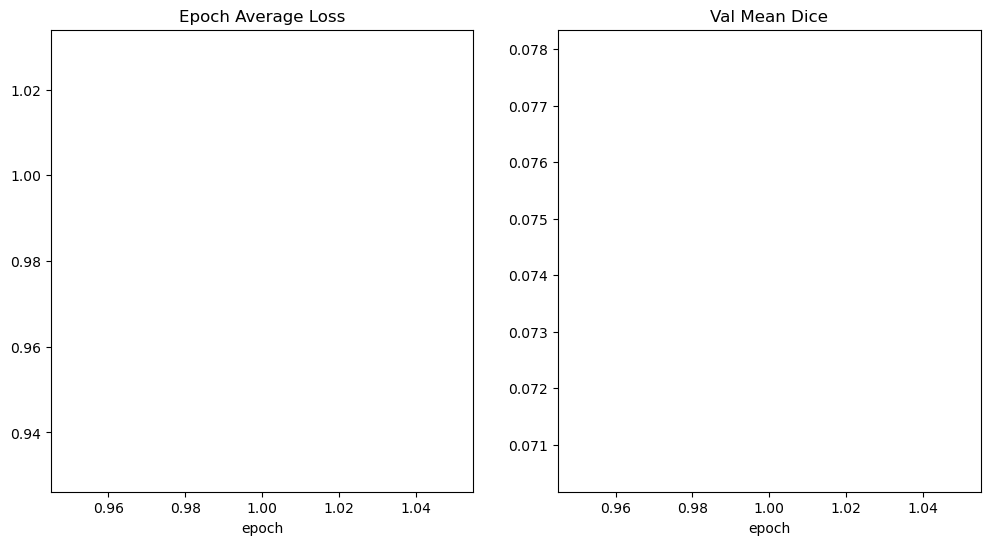

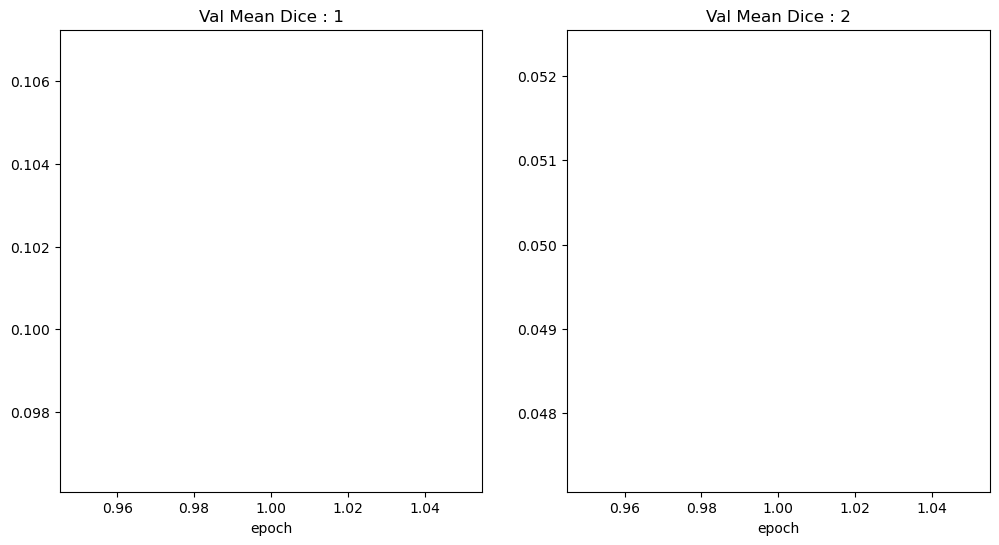

In [29]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Val Mean Dice : 1")
x = [val_interval * (i + 1) for i in range(len(metric_values_1))]
y = metric_values_1
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice : 2")
x = [val_interval * (i + 1) for i in range(len(metric_values_2))]
y = metric_values_2
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.show()

IndexError: index 1 is out of bounds for dimension 0 with size 1

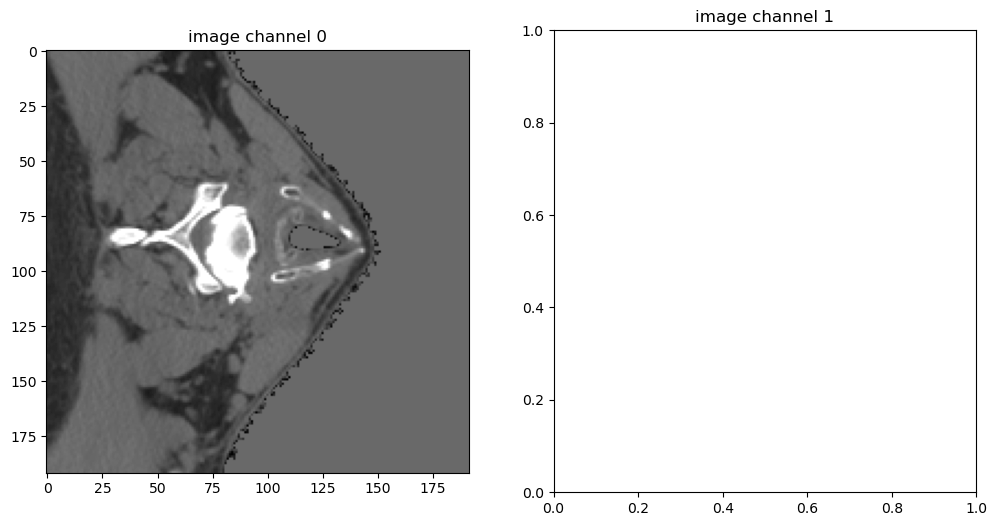

In [31]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_inputct = val_ds[1]["image"].unsqueeze(0).to(device)
    val_inputpt = val_ds[1]["image2"].unsqueeze(0).to(device)
    val_input = torch.concat([val_inputct, val_inputpt], axis=1)
    roi_size = (192, 192, 192)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (12, 6))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[1]["image"][i:, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (12, 6))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[1]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (12, 6))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()